In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/"My Drive"/"Colab Notebooks"/Northout

/content/drive/My Drive/Colab Notebooks/Northout


In [ ]:
import requests

r = requests.get("http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv")
with open("QuoraDuplicationDataset.tsv", "wb") as f:
    f.write(r.content)

            id  ... is_duplicate
0            0  ...            0
1            1  ...            0
2            2  ...            0
3            3  ...            0
4            4  ...            0
...        ...  ...          ...
404285  404285  ...            0
404286  404286  ...            1
404287  404287  ...            0
404288  404288  ...            0
404289  404289  ...            0

[404290 rows x 4 columns]


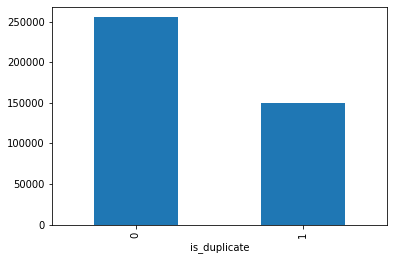

In [ ]:
# read dataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('QuoraDuplicationDataset.tsv', sep = "\t")
df.drop(['qid1','qid2'], axis=1, inplace=True)
print(df)
df.dropna(axis=0, inplace=True)
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
Model.run_eagerly = True
from keras import backend as K
np.random.seed(10)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
# enabling the pretrained model for trainig our custom model using tensorflow hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.KerasLayer(module_url)

# creating a method for embedding and will using method for every input layer 
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
DROPOUT = 0.1

# Taking the question1 as input and creating a embedding for each question before feed it to neural network
q1 = layers.Input(shape=(1,), dtype=tf.string)
embedding_q1 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q1)
print(embedding_q1)
# Taking the question2 and doing the same thing mentioned above, using the lambda function
q2 = layers.Input(shape=(1,), dtype=tf.string)
embedding_q2 = layers.Lambda(UniversalEmbedding, output_shape=(512,))(q2)

# Concatenating the both input layer
merged = layers.concatenate([embedding_q1, embedding_q2])
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

# Normalizing the input layer,applying dense and dropout  layer for fully connected model and to avoid overfitting 
merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

merged = layers.BatchNormalization()(merged)
merged = layers.Dense(200, activation='relu')(merged)
merged = layers.Dropout(DROPOUT)(merged)

# Using the Sigmoid as the activation function and binary crossentropy for binary classifcation as 0 or 1
merged = layers.BatchNormalization()(merged)
pred = layers.Dense(2, activation='sigmoid')(merged)
model = Model(inputs=[q1,q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m], run_eagerly=None)
model.summary()

Tensor("lambda/keras_layer/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                   

In [ ]:
q1= df.question1.tolist()
q2= df.question2.tolist()
labels= df.is_duplicate.tolist()

In [ ]:
from sklearn.model_selection import train_test_split
X1 = df['question1']
X2 = df['question2']
y = df['is_duplicate']
# Using the sklearn to split data in question1 and question2 train and test in the ration 80-20 %
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

train_q1 = X1_train.tolist()
train_q1 = np.array(train_q1, dtype=object)[:, np.newaxis]
train_q2 = X2_train.tolist()
train_q2 = np.array(train_q2, dtype=object)[:, np.newaxis]

train_labels = np.asarray(pd.get_dummies(y_train), dtype = np.int8)

test_q1 = X1_test.tolist()
test_q1 = np.array(test_q1, dtype=object)[:, np.newaxis]
test_q2 = X2_test.tolist()
test_q2 = np.array(test_q2, dtype=object)[:, np.newaxis]

test_labels = np.asarray(pd.get_dummies(y_test), dtype = np.int8)

In [ ]:
from keras.callbacks import ModelCheckpoint
  
filepath="drive/My Drive/Colab Notebooks/Northout/model-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
history = model.fit([train_q1, train_q2], 
        train_labels,
        validation_data=([test_q1, test_q2], test_labels),
        epochs=20,
        batch_size=512, callbacks=callbacks_list)
model.save(f'final_model_1.h5')

Epoch 1/20
632/632 [==============================] - 410s 649ms/step - loss: 0.4745 - acc: 0.7651 - f1_m: 0.7615 - precision_m: 0.7618 - recall_m: 0.7613 - val_loss: 0.4050 - val_acc: 0.8034 - val_f1_m: 0.8030 - val_precision_m: 0.8031 - val_recall_m: 0.8029
Epoch 2/20
632/632 [==============================] - 411s 651ms/step - loss: 0.3914 - acc: 0.8125 - f1_m: 0.8124 - precision_m: 0.8123 - recall_m: 0.8126 - val_loss: 0.3765 - val_acc: 0.8216 - val_f1_m: 0.8218 - val_precision_m: 0.8213 - val_recall_m: 0.8223
Epoch 3/20
632/632 [==============================] - 411s 651ms/step - loss: 0.3673 - acc: 0.8269 - f1_m: 0.8269 - precision_m: 0.8268 - recall_m: 0.8269 - val_loss: 0.3690 - val_acc: 0.8245 - val_f1_m: 0.8245 - val_precision_m: 0.8245 - val_recall_m: 0.8244
Epoch 4/20
632/632 [==============================] - 409s 648ms/step - loss: 0.3544 - acc: 0.8342 - f1_m: 0.8343 - precision_m: 0.8342 - recall_m: 0.8343 - val_loss: 0.3549 - val_acc: 0.8325 - val_f1_m: 0.8326 - val_pre

In [ ]:

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
# q1 = "why India is more successful in cricket than hockey?"  # player related
# q2 = "why in India cricket is more famous than hockey?"      # audience related
q1 = "Were the Clintons paid by the Clinton Foundation?"
q2 = "Was Chelsea Clinton really paid \$700,000 a year working for the Clinton Foundation ?"
q1 = np.array([[q1],[q1]])
q2 = np.array([[q2],[q2]])


model = load_model('drive/My Drive/Colab Notebooks/Northout/final_model.h5')  
print(model)
# predicts = model.predict([q1, q2], verbose=0)
# predict_logits = predicts.argmax(axis=1)
# print("----FINAL RESULT----")
# if(predict_logits[0] == 1):
#     print("Given Question Pair is Similar")
# else:
#     print("Given Question Pair is not Similar")

In [ ]:
print(model)